# Experiments with BaCOUn

AM 207 Final Project <br>
Harvard University <br>
Fall 2020

*Team Members: Hardik Gupta, Will Seaton, Johannes Kolberg, Matthieu Meeus*

We explore the paper [BaCOUn: Bayesian Classifiers with Out-of-Distribution Uncertainty](https://arxiv.org/pdf/2007.06096.pdf) and extend its research to new experiments over novel and diverse out-of-distribution (OOD) test datasets.

---
## Section 1: Paper Summary

In this section, we summarize the BaCOUn paper.

1. [Problem statement](#Problem-statement)
1. [Context](#Context)
1. [Existing work](#Existing-work)
1. [Contribution](#Contribution)
1. [Technical summary](#Technical-summary)
1. [Technical details](#Technical-details)
1. [Experiments](#Experiments)
1. [Evaluation and future work](#Evaluation-and-future-work)

### Problem statement

Most classifier models generate overconfident predictions for out-of-distribution samples, that is, for examples not representative of what the model was trained on. Ideally, we would want out-of-distribution samples to have higher uncertainty than in-distribution samples, and for the uncertainty to increase with the distance to the in-distribution data. This paper proposes a Bayesian framework for improving the uncertainty estimates of classifier models per these desiderata.

### Context

As algorithms increasingly become a keystone of decision making in many systems, the inability to detect out-of-distribution (OOD) data can result in disastrous failures. A model trained to make nuanced decisions is only efficacious when applied to data that is similar to that on which it was trained. For example, a facial recognition model trained on a set of input data (pictures of white men) likely performs very poorly on real-world data it has not seen before (pictures of black women), but the model has no ability to detect that the new real-world data is dissimilar to its training data. Hence the model is highly confident despite being highly inaccurate. Instead, we would like the model to detect when current data is OOD and consequently flag higher uncertainties when making predictions.

### Existing work

The paper highlights three approaches for generating estimates of predictive uncertainty in classification problems:

1. ***Gaussian Processes***

    Gaussian Processes (GPs) are a generalization of Gaussian probability distributions applied to functions, as opposed to being applied to random variables. For any given dataset, we can fit an infinite number of functions. GPs help us systematically assign probability distributions to these functions. They provide a kernel-based approach to modeling the data, making them flexible and therefore able to capture complex patterns. This flexibility allows GPs to generate accurate uncertainty estimates in both data-rich and data-poor regions. However, their flexibility also results in the computation eventually becoming very expensive as we continue to add observations to the dataset.


2. ***Bayesian Neural Networks***

    Bayesian Neural Networks (BNNs) refer to stochastic neural networks trained using a Bayesian paradigm. They incorporate prior beliefs over model parameters and measures of confidence in the occurrence of probabilistic events rather than predicting a frequency of event occurrence over time (i.e., a frequentist paradigm). Despite these desirable properties, conducting inference with BNNs remains challenging. This limits their usability in problem domains where we are particularly concerned about the models’ sensitivities to specific input variables.


3. ***Neural Linear Models***

    Neural Linear Models (NLMs) address some of the challenges associated with BNNs. Instead of placing priors on all model parameters, NLMs only place priors on the final network layer while simply learning point estimates for the remaining parameters. This makes inference much easier because the parameters in the final network layer can now be analytically represented.

The paper illustrates that GPs are able to effectively capture epistemic uncertainty in data-scarce regions, while BNNs and NLMs are not. To accurately capture OOD uncertainties in classification problems, the model must include decision boundaries that properly bound the given data. The training procedure for BNNs and NLMs do not do this, hence they underestimate epistemic uncertainty in data-scarce regions. This dynamic is reflected in the below figure from the paper.

![figure1](images/figure1.png)

### Contribution

The paper makes two key contributions:

1. Through pedagogical examples, the paper shows how BNN and NLM classifiers are unable to accurately model OOD uncertainty. Training of BNNs and NLMs does not encourage the learning of decision boundaries that properly bound the data. BNNs and NLMs therefore tend to underestimate epistemic uncertainty in data-scarce regions. <br>
<br>
1. The paper proposes a novel framework for training NLMs that allows them to generate accurate epistemic uncertainty for OOD data, while also generating accurate aleatoric uncertainty. This training framework achieves uncertainty estimates that are comparable to GPs while being much more scalable with dataset size.


### Technical summary

The proposed BaCOUn algorithm consists of the following steps:

1. Generate OOD samples along the boundaries of the data.
2. Train a deterministic classifier to separate the original classes and to distinguish them from the generated OOD samples.
3. Fix the features learned by the deterministic classifier, then fit a Bayesian logistic regression model on these features.

By adding generated OOD samples along the boundaries of the data, we allow the deterministic classifier to learn decision boundaries that bound the data. In the next step, we perform a standard Bayesian logistic regression on the latent features learned by the deterministic classifier. Because the learned features bound the data, the Bayesian logistic regression results in accurately capturing epistemic uncertainty for the OOD points.

### Technical details

NLM classifiers can be represented by the following equation:

$$
\begin{align}
y|x &\sim \textrm{Cat}(\textrm{softmax}(W^{T}\phi_\theta(x)) \\
W &\sim p(W)
\end{align}
$$

Here, $\phi_\theta(x)$ is the output of the trained neural network and is known as the feature map. The feature map is trained to maximize the log-likelihood of the data:

$$ \theta^* = \underset{\theta, W}{\textrm{argmax}} \log p(y_1, y_2, ... , y_n | x_1, x_2, ... , x_n, \theta, W) $$

We then fix the trained feature map, $\phi_\theta^*(x)$, infer the posterior $p(W| \mathcal{D}, \theta^*)$, and finally make predictions by computing the posterior predictive distribution:

$$ p(y^*|x^*, \mathcal{D}) = \int  p(y^*|x^*, W) p(W| \mathcal{D}, \theta^*) dW$$

where $\mathcal{D}$ is the training data with $N$ observations $\{(x_1, y_1), (x_2, y_2), ..., (x_N, y_N) \}$.

In order for NLMs to accurately estimate OOD uncertainty, the posteriors must include decision boundaries that bound the data-rich regions such that predictions outside these regions have higher uncertainty. The training objective for NLMs emphasizes learning decision boundaries that accurately predict the target category. Given this learning objective, trained NLMs are effective at solving the classification problem at hand, but tend to fail at OOD detection as the standard training procedure does not emphasize learning which data points are in- or out-of-sample. This failure mode is also observed in BNNs for the same reasons.

The paper introduces an improved framework for training NLMs such that they are able to better express epistemic uncertainty for OOD points while simultaneously solving the classification problem accurately. The proposed algorithm is called Bayesian Classifier with OOD Uncertainty (BaCOUn).

The BaCOUn algorithm consists of the following steps:

1. Generate OOD samples along the boundaries of the data.
2. Train a deterministic classifier to separate the original classes and to distinguish them from the generated OOD samples.
3. Fix the features learned by the deterministic classifier, then fit a Bayesian logistic regression model on these features.

Part of this training framework is to explicitly emphasize the detection of OOD points. The learned features are therefore better able to capture the decision boundaries that bound the in-sample data. As a result, the posterior distributions generated by the Bayesian logistic regression are able to accurately capture OOD uncertainty.

### Experiments

The paper tests its main concept on four different datasets - two real and two synthetic. In each experiment, the novel approach is evaluated on two points:

- By using the novel framework and decomposing total uncertainty into aleatoric and epistemic uncertainty, how much better is the model able to detect OOD points than traditional methods?

- Is the model successful in doing so without compromising its classification accuracy? 

On both accounts, BaCOUn is compared against traditional methods like GP, NLM, BNN, and MC-Dropout. 

Before diving into the experiments, note that the paper introduces a mathematically straightforward decomposition of the total uncertainty into epistemic and aleatoric uncertainty. Both the total uncertainty and its decomposition is computed for three types of data: ‘In’ points in data-dense regions with no class overlap; ‘Middle’ points in data-dense regions with some class overlap; and ‘Out’ points far from data-dense regions, i.e., OOD data. For the OOD data points, the aim is to recover large values for the epistemic uncertainty, and significantly larger than for aleatoric uncertainty. For regions with high class overlap, we expect to recover high aleatoric uncertainty.

All the experiments appear to prove that BaCOUn returns consistently higher values of epistemic uncertainty for OOD data, without compromising overall accuracy of in-distribution predictions. 

**GMM**: The first synthetic dataset is built using a Gaussian Mixture Model in two dimensions. The authors manually determine three means and, by adding some noise to recover class overlap, three clusters of 500 points each are constructed. The results for the three types considered (In, Middle and Out) are listed in the table below:

![table1](images/table1.png)

First, we notice that the accuracies are consistently high for all models. Both GP and BaCOUn are able to return high epistemic uncertainties for the OOD points. From this experiment, it is clear that BaCOUn matches the performance of GP, which the paper considers as the gold standard in detecting OODs.

**Moon-shaped data**: The second synthetic dataset is generated using sklearn‘s built-in “two-moons” data generator. The following figure illustrates the toy data, as well as the total uncertainty in the 2D space for each method. 

![figure9](images/figure9.png)

Note that MC-Dropout and NLM are unable to recover high uncertainties for points far from data-dense regions, whereas GP and BaCOUn clearly do. Moreover, the latter two do so without compromising the uncertainty that is expected at the class overlap. The paper provides convincing results of the decomposition of the uncertainty, which strongly supports the claim that BaCOUn is the only method that is able to obtain GP-like uncertainty while remaining more computationally efficient than GP. Note that for this particular dataset, the similarity is more visually and thus qualitatively supported than quantitatively.

**UCI Wine Quality**: The paper continues with a first real dataset: the well-known wine-quality dataset where only two classes are selected: wines with scores 5 or 7. The uncertainty is computed for held-out data points from these classes, from the other entirely held-out classes, and from synthetically placed OOD data along the boundary. The below boxplots of the epistemic and aleatoric uncertainties illustrate an excellent comparison between all the methods:

![figure6](images/figure6.png)

Recall that we in these models desire high epistemic and low aleatoric uncertainty for OOD points. From the figure, it is obvious that only the BaCOUn framework convincingly expresses this desired property. As the differences compared to traditional models are so significant on a real and ubiquitous dataset, this is arguably among the most compelling results of the paper when it comes to demonstrating the capabilities of this novel framework.

**MNIST**: Lastly, BaCOUn is tested on the widely used MNIST dataset for handwritten digit recognition. Now the OOD points come from altogether separate image datasets, namely USPS, EMNIST and CIFAR. This is especially interesting, as these images are indubitably ‘out-of-distribution’ based on human intuition, but this does not necessarily translate as obviously to a quantitative perspective as far as the models are aware. 

In the below boxplots, we can compare the distribution of the decomposed uncertainties. Unlike in the previous examples, the competitors of BaCOUn are now clearly able to generate higher epistemic uncertainty for OOD points. In this case, the paper argues that the distinct value of BaCOUn over the other models is that the aleatoric uncertainty is significantly lower for the OOD data. While a fair point, it is less obviously compelling evidence than on the wine quality dataset.

![figure7](images/figure7.png)

![figure8](images/figure8.png)

Additionally, the paper includes three other visually satisfying qualitative experiments using selected MNIST examples. First, they plot the uncertainty when transitioning from one class to another in a trained VAE latent dimension. Here, we notice that both uncertainties grow when the point is farther away from a clear ‘digit’, and decreases when it re-enters a class-dense region. 

Next, an image is considered with an increasing amount of Gaussian noise. As such, the point is moved increasingly outside data-dense regions, and we observe that the epistemic uncertainty increases while the aleatoric does not to a significant extent. 

Lastly, the paper shows the change in uncertainty when the image is rotated. This is especially interesting when the image contains digits 6, 9 or 1. In the figure below, we notice an almost sinusoidal variation in the uncertainties. While none of the experiments yield compelling quantitative evidence, it is qualitatively convincing that the BaCOUn framework obtains uncertainties that make sense in accordance with human, visual intuition; for instance, rotating a digit 9 by near 180 degrees makes uncertainty fall dramatically as it increasingly resembles a digit 6. 

![figure29](images/figure29.png)

### Evaluation and future work

Overall, we strongly believe in the capabilities of the novel framework for uncertainty introduced by the paper. The idea is conceptually very simple and intuitive, it’s easily generalizable to a swathe of classification model families, and the results from the experiments are on the whole convincing.

The method of decomposing the total uncertainty into epistemic and aleatoric uncertainty seems highly sensible – a fact we only truly realized while reproducing the results for ourselves, as can be seen in our notebook.

Implementing this decomposition together with the BaCOUn framework appears to be a powerful and flexible tool. It is quantitatively sound – especially in the GMM and Wine Quality experiments – and qualitatively convincing – especially in the Moon and MNIST experiments.

On the other hand, we had the following points of critique/need for future work:
- For the experiments with synthetic data, the paper is successful in supporting the claim that BaCOUn returns GP-like results. However, it is not entirely clear why we should use BaCOUn instead of GP.
- While the paper is successfully advocating for its method, it does not elaborate on potential costs associated with the BaCOUn framework. It would be great to have an estimate on the added computational costs, in case a trade-off would need to be made.
- Regarding the experiments with the MNIST data, the traditional competitors of BaCOUn deliver very sound epistemic uncertainty for OOD points. We agree that it is very powerful that the corresponding aleatoric uncertainty is only convincingly lower for BaCOUn, but one might say that we could still use the other methods to detect OOD points based on the epistemic uncertainty alone. 

- While the determination of the OODs for the images is very intuitive from a human perspective, this is not really quantified. We understand that this is a challenging task in general, which is also why we’ll explore this further during our personal experimentation with the framework. 

---
## Section 2: BaCOUn Implementation and Pedagogical Examples

In the following sections, we'll explore our implementation of the BaCOUn framework applied to image classification using CNNs on the CIFAR-10 dataset. We'll go through the following steps:

1. [Build a CNN for CIFAR-10 and visualize latent space](#Build-a-CNN-for-CIFAR-10-and-visualize-latent-space)
    - Start off by building a baseline CNN model with desirable accuracy across the 10 classes. Our final architecture led +78% validation accuracy and weights saved to Model_Dec5.h5. 
    - t-SNE and PCA visulaization of last hidden layer. PCA specifally will be used to visualize our OOD points. 
    - PCA of training data and the OOD projection. We'll use OODs coming from CIFAR-100, MNIST and CelebA.


2. [Build a deterministic classifier for K+1 classes](#Build-a-deterministic-classifier-for-K+1-classes)
    - Train a deterministic classifier to distinguish between the original K classes and between the newly generated OOD samples. 
    - The classifier is a CNN with the same architecture as our baseline model before with a softmax output activation with 11 outputs, so all classes of CIFAR-10 and the OOD. We got a validation accuracy of 72% and the weights are stored in model_OOD_Dec5.h5. 


3. [Implement BaCOUn](#Implement-BaCOUn)
    - In this step we'll implement the last step from the paper and build our Bayesian model. 
    - For this we'll use 10 classes again! We get rid of the OOD points and just train with the original training data. The idea is now that we'll recover a Bayesian model that returns high uncertainty when it's used to perform inference on OOD. 
    - We'll do this using pymc3 with 5k training data points
    - We got an accuracy on the training set:  0.93662 and on the test set:  0.7925 with posterior mean predictions. 
    - Saved the samples from posterior - as the sampling took quite some time, so the samples are easy to access.


4. [Decompose uncertainty](#Decompose-uncertainty)

    - We then implement a way of mathematically decomposing the total uncertainty in epistemic and aleatoric uncertainty. From Appendix C of the paper we understand:

        1. The total predictive uncertainty about a point can be calculated in the following way:
            - draw multiple samples of parameters from the posterior
            - for each sample, calculate a prediction (i.e. a vector of probabilities adding up to 1)
            - find the mean probability vector and calculate the entropy of that.
        2. Aleatoric uncertainty is approximated as follows:
            -  for each sample, calculate a prediction (i.e. a vector of probabilities adding up to 1) and the entropy of this prediction
            - calculate the average of the entropies

        3. Then, epistemic uncertainty is Total minus Aleatoric.


5. [Test and compare different kinds of OOD](#Test-and-compare-different-kinds-of-OOD)

    - We'll now experiment with different kinds of OOD points and analyse whether BaCOUn returns the high epistemic and low aleatoric uncertainty as is hoped for. We'll use samples from CIFAR-100, MNIST and CelebA. 

In [ ]:
# Mount Google drive for access
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/AM207_BaCOUn/

In [ ]:
# Import packages
import pathlib
import os
import gc
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import pymc3 as pm
import theano.tensor as T

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from tensorflow.keras import datasets, layers, models, callbacks
from scipy.stats import entropy
from pymc3 import Model
from tqdm import tqdm

%matplotlib inline
AUTOTUNE = tf.data.experimental.AUTOTUNE
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

## Build a CNN for CIFAR-10 and visualize latent space

#### Load data

We start by downloading CIFAR-10 from a hosted solution by TensorFlow and apply pixel normalization. CIFAR-10 is an image dataset containing 60,000 32x32 color images of 10 classses.

In [ ]:
# Load data from TensorFlow
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

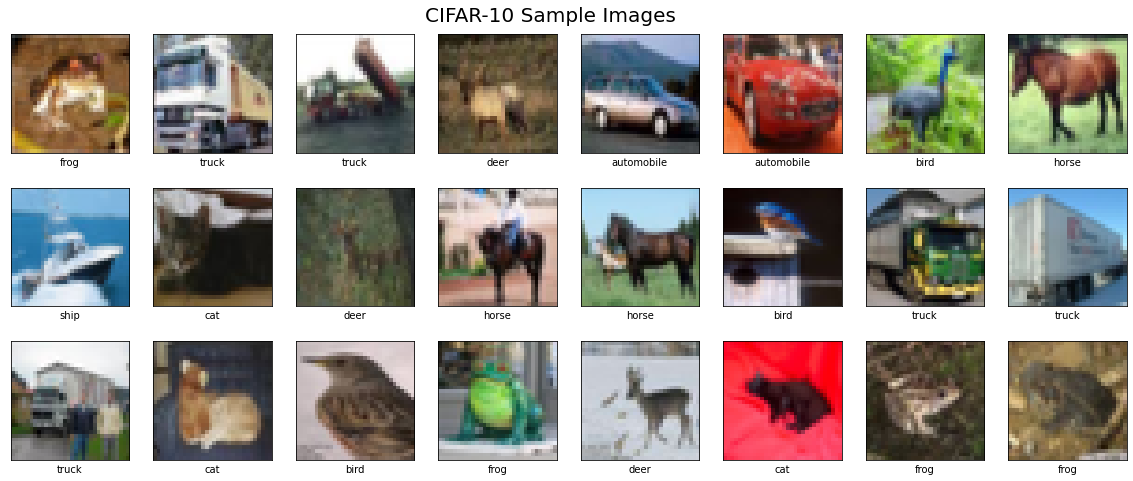

In [ ]:
# Manually store class labels in dictionary
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cdict = {i: class_name for i, class_name in enumerate(class_names)}

# Plot sample images
plt.figure(figsize=(20,8))
for i in range(24):
    plt.subplot(3,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra 0 index
    plt.xlabel(class_names[train_labels[i][0]])
plt.suptitle("CIFAR-10 Sample Images", fontsize=20, y=.92)
plt.show()

#### Build and train model
We design a simple convolutional neural network consisting of six 3x3 Conv2D layers, interspersed with three MaxPooling2D and multiple Dropout layers. We conclude with a softmax activation function given our desire to classify images into our chosen classes.

In [ ]:
# Design manual CNN using TensorFlow Sequential() function
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu', name = 'hidden'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

In [ ]:
# Manually specify suffix according to data of model run
suffix = 'Dec5'

# Custom class to wrap a Keras Callback in
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

# Apply Callback through Model Checkpoint to save best weights
callbacks_list = [
    MyCustomCallback(), 
    callbacks.ModelCheckpoint(
        filepath='model_{}.h5'.format(suffix), monitor='val_accuracy', 
        save_best_only=True, save_weights_only=True, mode='max')
]

# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Fit model on training images and labels
history = model.fit(
    train_images, train_labels, 
    epochs=5, #20
    validation_data=(test_images, test_labels),
    batch_size=64,
    callbacks=callbacks_list
)

In [ ]:
# Load pre-fit weights
suffix = 'Dec5'
model.load_weights('drive/MyDrive/AM207_BaCOUn/model_{}.h5'.format(suffix))

In [ ]:
# # Plot training history
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

# Print performance evaluation
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

313/313 - 18s - loss: 0.6664 - accuracy: 0.7852


#### Visualizing hidden features

We want to get an understanding of the separation that our model provides on the test CIFAR-10 dataset. To do this, we use t-distributed stochastic neighbor embedding (t-SNE), an algorithm for dimensionality reduction to a plottable 2-D representation.

In [ ]:
# Construct feature_extractor from our designed and fit model
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer('hidden').output)
test_features = feature_extractor.predict(test_images)

In [ ]:
# Retrieve labels as list
train_labels_plot = [k[0] for k in train_labels]
test_labels_plot = [k[0] for k in test_labels]

In [ ]:
%%time
# Apply TSNE() to extracted features
tsne = TSNE().fit_transform(test_features)
tx, ty = tsne[:,0], tsne[:,1]
# Normalize
tx = (tx-np.min(tx)) / (np.max(tx)-np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty)-np.min(ty))

CPU times: user 4min 36s, sys: 474 ms, total: 4min 36s
Wall time: 3min 9s


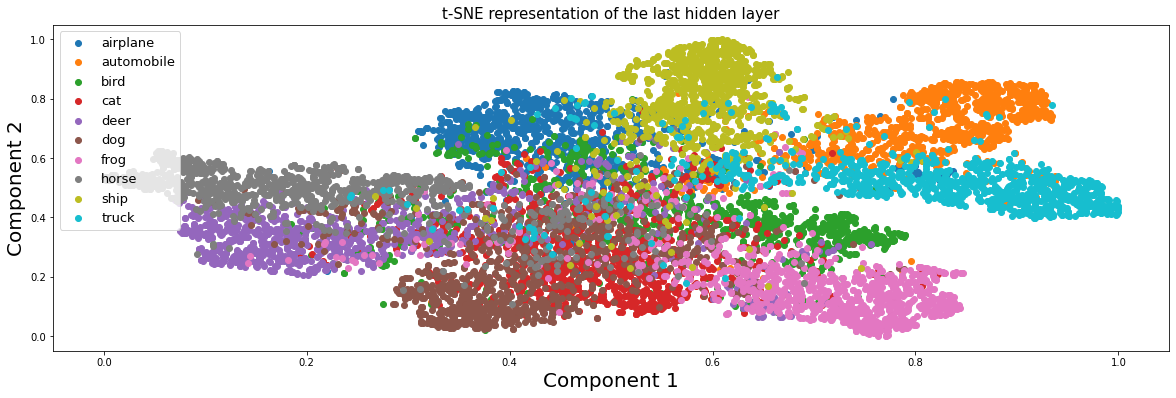

In [ ]:
# Plot t-SNE representation
plt.figure(figsize = (20,6))
for g in np.unique(test_labels_plot):
    ix = np.where(test_labels_plot == g)
    plt.scatter(tx[ix], ty[ix], label=cdict[g])
plt.title('t-SNE representation of the last hidden layer', fontsize=15)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.legend(fontsize=13)
plt.show()

In [ ]:
# Apply Principal Component Analysis (PCA) to retrieve explained variance ratio
# Which features explain most of the variance in plot performance?
pca = PCA(n_components=2)
pca_projection = pca.fit_transform(test_features)
pcax, pcay = pca_projection[:, 0], pca_projection[:, 1]
print(pca.explained_variance_ratio_)

[0.23655325 0.10914849]


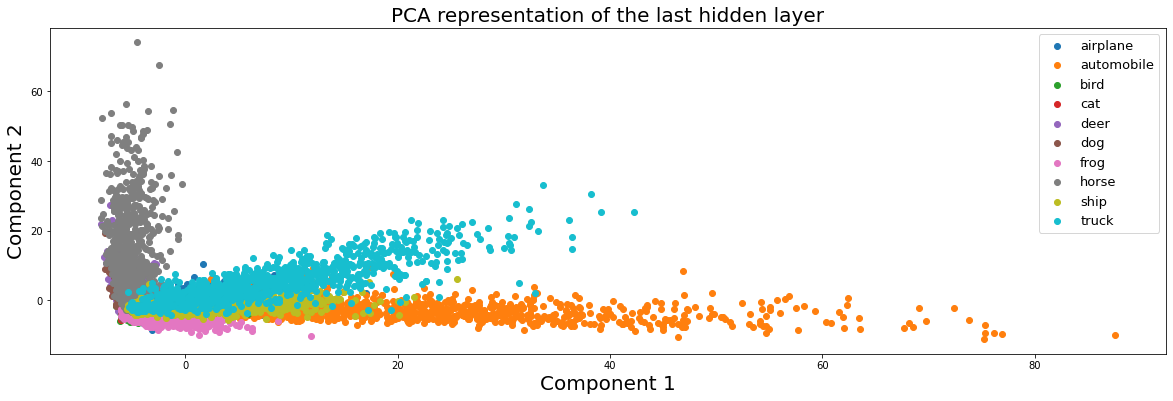

In [ ]:
# Plot PCA representation
plt.figure(figsize = (20,6))
for g in np.unique(test_labels_plot):
    ix = np.where(test_labels_plot == g)
    plt.scatter(pcax[ix], pcay[ix], label=cdict[g])
plt.title('PCA representation of the last hidden layer', fontsize=20)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.legend(fontsize=13)
plt.show()

#### Adding Out-of-Distribution (OOD) points

We now want to assess the placement and performance of OOD points within our model. We retrieve new points from multiple datasets previously unseen by the model so that we can assess generalizable uncertainty production.

Note that OOD for images is hard to define and hard to visualize. In this case, we'll only consider data that is OOD from a human perspective and we'll use PCA in 2 dimensions to visualize our data and OOD. We do realize that these components only capture parts of the total variance so that a visual inspection of OOD in this 2D space is far from exact. 

#### CIFAR-100 as OOD

CIFAR-100 is an identical image dataset to CIFAR-100, but it contains 100 classes of 600 images each, still totalling 60,000.

In [ ]:
# Load CIFAR-100 from TensorFlow
(x_train_cifar100_OOD, y_train_cifar100_OOD), (x_test_cifar100_OOD, y_test_cifar100_OOD) = datasets.cifar100.load_data()
x_train_cifar100_OOD, x_test_cifar100_OOD = x_train_cifar100_OOD / 255.0, x_test_cifar100_OOD / 255.0

169009152/169001437 [==============================] - 4s 0us/step


In [ ]:
# Prepare tracking variables
cifar100_OOD = []
n_OOD = 1000

# Randomly select n_OOD images and append to new list
for i in np.random.choice(range(len(x_train_cifar100_OOD)), n_OOD):
    cifar100_OOD.append(x_train_cifar100_OOD[i])
#     plt.imshow(x_train_OOD[i])
#     plt.title(y_train_OOD[i])
#     plt.show()

# Apply feature_extractor to randomly selected OOD points
cifar100_OOD = np.array(cifar100_OOD)
cifar100_OOD_features = feature_extractor.predict(cifar100_OOD)
cifar100_OOD_features.shape

(1000, 512)

In [ ]:
# Apply PCA to CIFAR-100 features
pca_cifar100_OOD = pca.transform(cifar100_OOD_features)
pcax_cifar100_OOD, pcay_cifar100_OOD = pca_cifar100_OOD[:, 0], pca_cifar100_OOD[:, 1]

In [ ]:
# Confirm shape
pcax_cifar100_OOD.shape

(1000,)

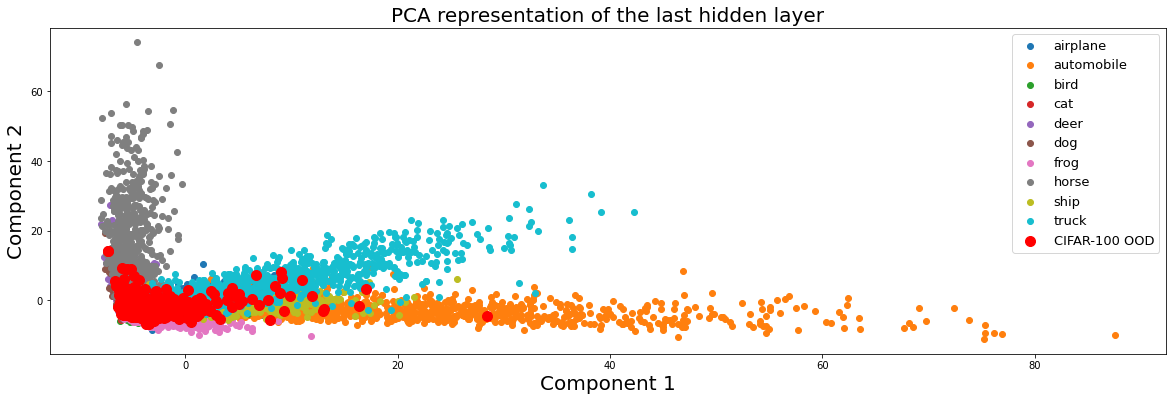

In [ ]:
# Plot PCA representation
plt.figure(figsize=(20,6))
for g in np.unique(test_labels_plot):
    ix = np.where(test_labels_plot == g)
    plt.scatter(pcax[ix], pcay[ix], label=cdict[g])
plt.scatter(pcax_cifar100_OOD, pcay_cifar100_OOD, label='CIFAR-100 OOD', c='red', s=100)
plt.title('PCA representation of the last hidden layer', fontsize=20)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.legend(fontsize=13)
plt.show()

#### CelebA as OOD

Our next OOD test dataset is CelebFaces Attributes Datsaet (CelebA), a large-scale face attributes dataset with more than 200k celebrity images. Each image has 40 attribute annotations should we wish to use those.

In [ ]:
# Creating path to dataset
dataset_path = "drive/MyDrive/AM207_BaCOUn/Data/celeba/"
data_dir = pathlib.Path(dataset_path + "img_align_celeba/")
print("Directory Location: ", data_dir)

# Saving image count
image_count = len(list(data_dir.glob('*.jpg')))
print("number of images available: {:,}".format(image_count))

Directory Location:  drive/MyDrive/AM207_BaCOUn/Data/celeba/img_align_celeba
number of images available: 202,599


In [ ]:
%%time
# Creating list of image files
list_ds = tf.data.Dataset.list_files(str(data_dir/'*'), shuffle=False)
assert len(list_ds) == image_count

# Creating train and validation datasets from list
val_size = int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

CPU times: user 14 s, sys: 13.8 s, total: 27.7 s
Wall time: 54.5 s


In [ ]:
# Define image parameters
img_height = 32
img_width = 32
batch_size = 32

def get_image_id(file_path):
    """
    Function converts file path to list of path components
    """
    file_name = tf.strings.split(file_path, os.path.sep)[-1]
    image_id = tf.strings.split(file_name, ".")[0]
    return image_id

def decode_img(img):
    """
    Function converts compressed string to a 3-D uint8 tensor
    """
    # Decode JPEG
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize image to specified size
    img = tf.image.resize(img, [img_height, img_width])
    # Normalize pixel values
    img = tf.cast(img, tf.float32)/255.
    return img

def process_path(file_path):
    """
    Function loads image and id from provided file path
    """
    # Convert file path to path components
    image_id = get_image_id(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Compress to tensor
    img = decode_img(img)
    return img, image_id

# Pull image and image id
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

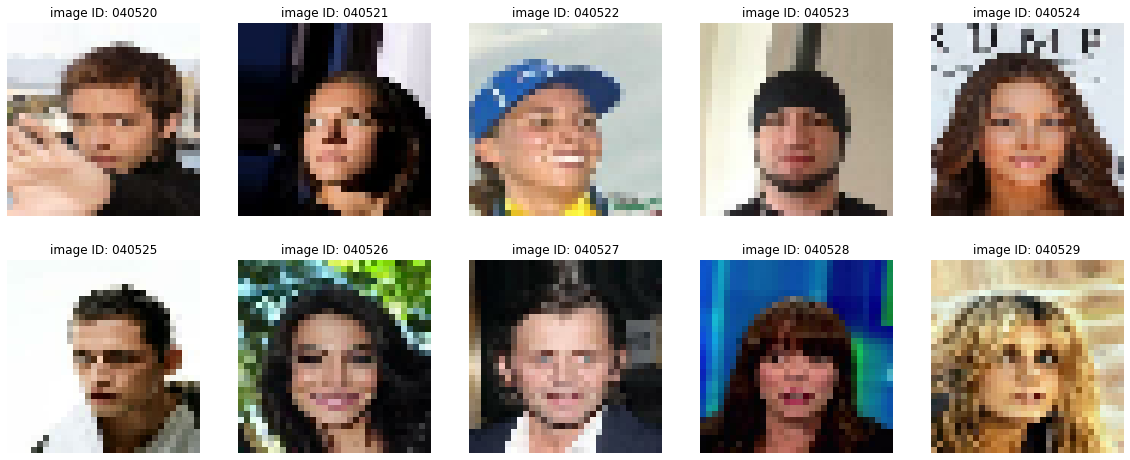

In [ ]:
# Plot sample images
fig, axs = plt.subplots(2,5, figsize=(20, 8))
axs_iter = iter(axs.flatten())
sample = train_ds.take(10)
image_id_list = []
for image, image_id in sample:
    ax = next(axs_iter)
    ax.imshow(image)
    ax.set_title(f"image ID: {image_id.numpy().decode('utf-8')}")
    image_id_list.append(image_id.numpy().decode("utf-8"))
    ax.axis("off")
plt.show()

In [ ]:
# Prepare tracking variables
celeba_OOD = []
n_OOD = 1000
sample = train_ds.take(n_OOD)

# Retrieve n_OOD images as list
for image, image_id in sample:
    celeba_OOD.append(image.numpy())
    
# Extract features from sample images
celeba_OOD = np.array(celeba_OOD)
celeba_OOD_features = feature_extractor.predict(celeba_OOD)
celeba_OOD_features.shape

(1000, 512)

In [ ]:
# Perform PCA on features
pca_celeba_OOD = pca.transform(celeba_OOD_features)
pcax_celeba_OOD, pcay_celeba_OOD = pca_celeba_OOD[:, 0], pca_celeba_OOD[:, 1]

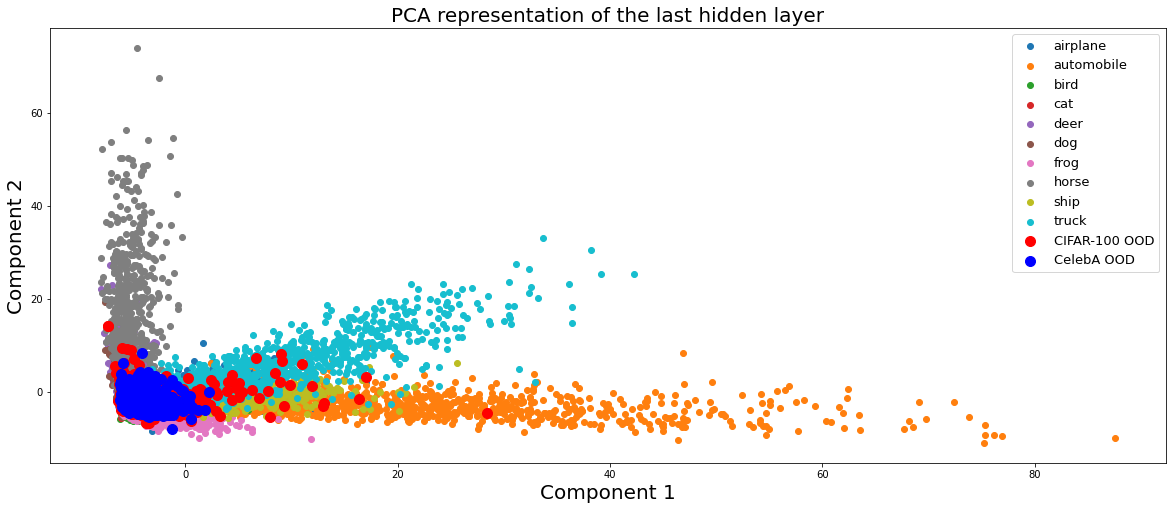

In [ ]:
# Plot PCA representation
plt.figure(figsize=(20, 8))
for g in np.unique(test_labels_plot):
    ix = np.where(test_labels_plot == g)
    plt.scatter(pcax[ix], pcay[ix], label=cdict[g])
plt.scatter(pcax_cifar100_OOD, pcay_cifar100_OOD, label='CIFAR-100 OOD', c='red', s=100)
plt.scatter(pcax_celeba_OOD, pcay_celeba_OOD, label='CelebA OOD', c='blue', s=100)
plt.title('PCA representation of the last hidden layer', fontsize=20)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.legend(fontsize=13)
plt.show()

#### MNIST as OOD

Our last OOD test dataset is MNIST, an image dataset of 60,000 examples of handwritten digits.

In [ ]:
# Fetch the dataset 
mnist = tfds.builder('mnist')

# Test whether fetching worked
assert mnist.info.features['image'].shape == (28, 28, 1)
assert mnist.info.features['label'].num_classes == 10
assert mnist.info.splits['train'].num_examples == 60000

# Download the data, prepare it, and write it to disk
mnist.download_and_prepare()

# Load data from disk as tf.data.Datasets
datasets = mnist.as_dataset()
train_dataset, test_dataset = datasets['train'], datasets['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Prepare tracking variables
mnist_OOD = []
n_OOD = 1000
sample = train_dataset.take(n_OOD)

# Process and save n_OOD sample images
for item in sample:
    img = item['image']
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32)/255.
    mnist_OOD.append(img.numpy())
    
# Extract features from sample images
mnist_OOD = np.array(mnist_OOD)
mnist_OOD_features = feature_extractor.predict(mnist_OOD)
mnist_OOD_features.shape

(1000, 512)

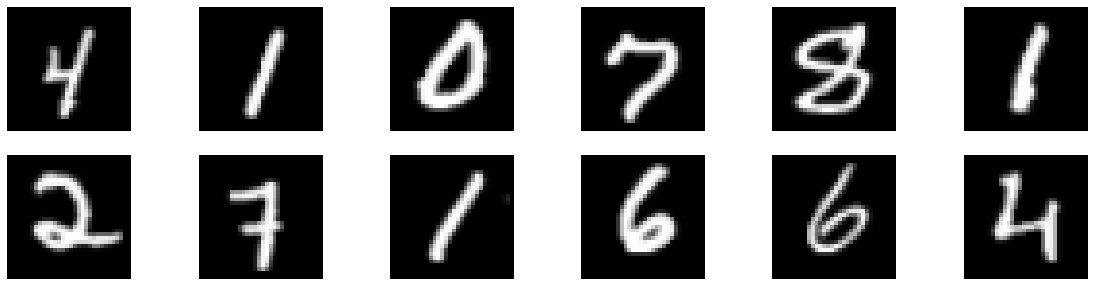

In [ ]:
# Plot sample images
fig, axs = plt.subplots(2,6, figsize=(20, 5))
axs_iter = iter(axs.flatten())
sample = mnist_OOD[0:12]
image_id_list = []
for image in sample:
    ax = next(axs_iter)
    ax.imshow(image)
    ax.axis("off")
plt.show()

In [ ]:
# Perform PCA on sample images
pca_mnist_OOD = pca.transform(mnist_OOD_features)
pcax_mnist_OOD, pcay_mnist_OOD = pca_mnist_OOD[:, 0], pca_mnist_OOD[:, 1]

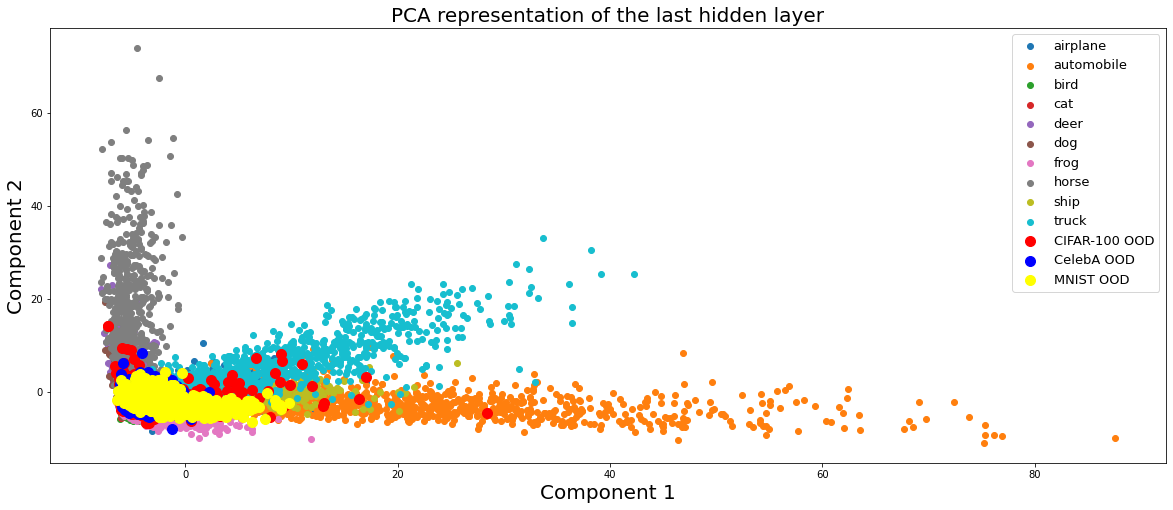

In [ ]:
# Plot PCA representation
plt.figure(figsize=(20, 8))
for g in np.unique(test_labels_plot):
    ix = np.where(test_labels_plot == g)
    plt.scatter(pcax[ix], pcay[ix], label=cdict[g])
plt.scatter(pcax_cifar100_OOD, pcay_cifar100_OOD, label='CIFAR-100 OOD', c='red', s=100)
plt.scatter(pcax_celeba_OOD, pcay_celeba_OOD, label='CelebA OOD', c='blue', s=100)
plt.scatter(pcax_mnist_OOD, pcay_mnist_OOD, label='MNIST OOD', c='yellow', s=100)
plt.title('PCA representation of the last hidden layer', fontsize=20)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.legend(fontsize=13)
plt.show()

The PCA plots show that added OOD points are *not* clearly distinguishible from the in-sample points across the first two principle components. Detecting OOD points based on PCA alone is not possible. We'll see below that the BaCOUn algorithm does a good job in detecting these OOD points.

## Build a deterministic classifier for K+1 classes

We'll first add OOD points to the training data (with an amount so that we get a balanced set) and will train a new CNN model with K + 1 = 11 classes to predict. The additional class then represents OOD. 

We use CIFAR-100 as the OOD points here since they are close to CIFAR-10, but consitute classes not included in CIFAR-10.

We'll use the same architecture as before, but now with a final softmax layer with 11 outputs instead of 10. 

From here, we'll build a 'feature-extractor' that projects input images on the last hidden layer of this trained CNN classifier and use these features to move on. 

In [ ]:
# First make sure we add a reasonably balanced class of OODs
# Count the classes of CIFAR-10
print('For the training data: ')
display(np.unique(train_labels, return_counts=True))
print('For the test data: ')
display(np.unique(test_labels, return_counts=True))

For the training data: 


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

For the test data: 


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [ ]:
# We need 5,000 random data points from CIFAR-100 for training and 1000 for testing

def add_OOD(x_train, y_train, x_test, y_test, x_OOD, n_train=5000, n_test=1000, OOD_label=10):
    """
    Function to insert random selection of OOD data into x/y_train/test
    Returns expanded versions of these arrays
    """
    
    # Random selection from x_OOD
    samples_idx = np.random.choice(range(len(x_OOD)), size=n_train+n_test, replace=False)
    samples = x_OOD[samples_idx]

    # Add random samples to x_train/test
    x_train_w_OOD = np.concatenate((x_train, samples[:n_train]), axis=0)
    x_test_w_OOD = np.concatenate((x_test, samples[n_train:]), axis=0)

    # Add random samples to y_train/test
    y_train_w_OOD = np.concatenate((y_train, np.ones((n_train, 1))*OOD_label), axis=0)
    y_test_w_OOD = np.concatenate((y_test, np.ones((n_test, 1))*OOD_label), axis=0)

    return x_train_w_OOD, y_train_w_OOD, x_test_w_OOD, y_test_w_OOD

In [ ]:
# Run function and save expanded OOD
x_train_w_OOD, y_train_w_OOD, x_test_w_OOD, y_test_w_OOD = add_OOD(train_images, train_labels, 
                                                                   test_images, test_labels, 
                                                                   x_train_cifar100_OOD)

In [ ]:
# Confirm unique class count
np.unique(y_train_w_OOD, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [ ]:
# Design new CNN model using TensorFlow Sequential()
model_OOD = models.Sequential()
model_OOD.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))
model_OOD.add(layers.Dropout(0.2))
model_OOD.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_OOD.add(layers.MaxPooling2D((2, 2)))
model_OOD.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_OOD.add(layers.Dropout(0.2))
model_OOD.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_OOD.add(layers.MaxPooling2D((2, 2)))
model_OOD.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_OOD.add(layers.Dropout(0.2))
model_OOD.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_OOD.add(layers.MaxPooling2D((2, 2)))
model_OOD.add(layers.Flatten())
model_OOD.add(layers.Dropout(0.2))
model_OOD.add(layers.Dense(1024, activation='relu'))
model_OOD.add(layers.Dropout(0.2))
model_OOD.add(layers.Dense(512, activation='relu', name = 'hidden'))
model_OOD.add(layers.Dropout(0.2))
model_OOD.add(layers.Dense(11, activation='softmax'))
model_OOD.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)       

In [ ]:
# Manual specify suffix of run
suffix = 'OOD_Dec5'

# Define custom class
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

# Apply class to callbacks for model checkpointing
callbacks_list = [
    MyCustomCallback(), 
    callbacks.ModelCheckpoint(
        filepath='model_{}.h5'.format(suffix), monitor='val_accuracy', 
        save_best_only=True, save_weights_only=True, mode='max')
]

# Compile model
model_OOD.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Fit model
history = model_OOD.fit(
    x_train_w_OOD, y_train_w_OOD, 
    epochs=20, 
    validation_data=(x_test_w_OOD, y_test_w_OOD),
    batch_size=64,
    callbacks=callbacks_list
)

In [ ]:
# Load pre-fit weights
suffix = 'OOD_Dec5'
model_OOD.load_weights('drive/MyDrive/AM207_BaCOUn/model_{}.h5'.format(suffix))

In [ ]:
# # Plot model history
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

# Save and print model evaluation
test_loss, test_acc = model_OOD.evaluate(x_test_w_OOD,  y_test_w_OOD, verbose=2)

344/344 - 20s - loss: 0.7933 - accuracy: 0.7452


In [ ]:
# Let's get the train and test accuracy of OOD points:

print('For train: ')
train_predictions = np.argmax(model_OOD.predict(x_train_w_OOD), axis=-1)
print(classification_report(y_train_w_OOD, train_predictions))

print('For test: ')
test_predictions = np.argmax(model_OOD.predict(x_test_w_OOD), axis=-1)
print(classification_report(y_test_w_OOD, test_predictions))

For train: 
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      5000
         1.0       0.96      0.98      0.97      5000
         2.0       0.79      0.94      0.86      5000
         3.0       0.79      0.85      0.82      5000
         4.0       0.86      0.93      0.90      5000
         5.0       0.84      0.88      0.86      5000
         6.0       0.92      0.91      0.92      5000
         7.0       0.95      0.94      0.94      5000
         8.0       0.92      0.98      0.95      5000
         9.0       0.93      0.97      0.95      5000
        10.0       0.78      0.40      0.53      5000

    accuracy                           0.88     55000
   macro avg       0.88      0.88      0.88     55000
weighted avg       0.88      0.88      0.88     55000

For test: 
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80      1000
         1.0       0.89      0.89      0.89      1000
 

In [ ]:
# Print the class names
class_names_w_OOD = class_names + ['OOD']
for i, class_name in enumerate(class_names_w_OOD):
    print(i, class_name)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck
10 OOD


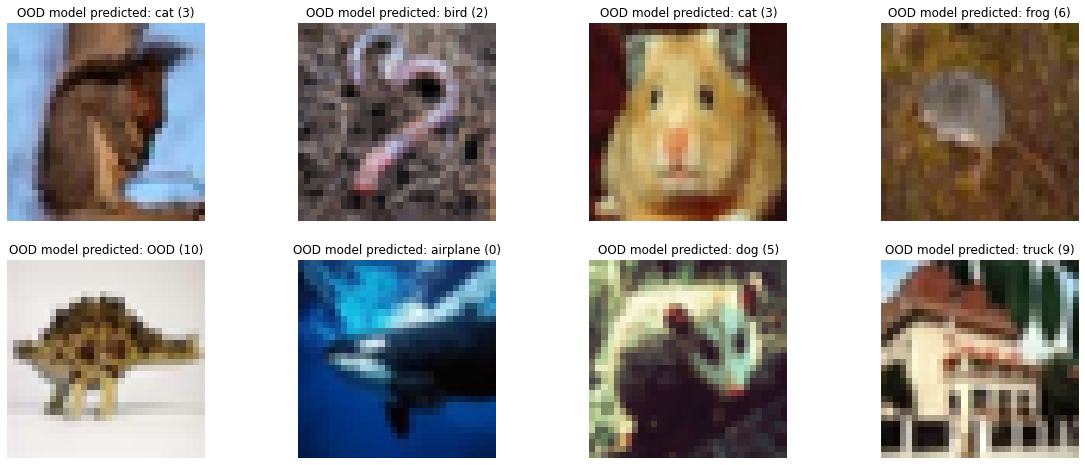

In [ ]:
# let's get some random CIFAR-100 samples and see if the model classifies it correctly:
n_test_OOD_detection = 8
samples_idx = np.random.choice(range(len(x_train_cifar100_OOD)), size=n_test_OOD_detection, replace=False)
samples = x_train_cifar100_OOD[samples_idx]
predictions = model_OOD.predict(samples)

# Preview samples
fig, axs = plt.subplots(2,4, figsize=(20,8))
axs_iter = iter(axs.flatten())
for i, sample in enumerate(samples):
    ax = next(axs_iter)
    ax.imshow(sample)
    pred = np.argmax(predictions[i])
    ax.set_title('OOD model predicted: {} ({})'.format(class_names_w_OOD[pred], pred))
    ax.axis("off")
plt.show()

In [ ]:
# Print predictions and score for CelebA
print('For CelebA: ')
celeba_predictions = np.argmax(model_OOD.predict(celeba_OOD), axis=-1)
print(classification_report(np.array([10]*celeba_predictions.shape[0]), celeba_predictions))

For CelebA: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       1.00      0.32      0.48      1000

    accuracy                           0.32      1000
   macro avg       0.09      0.03      0.04      1000
weighted avg       1.00      0.32      0.48      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print predictions and score for MNIST
print('For MNIST: ')
mnist_predictions = np.argmax(model_OOD.predict(mnist_OOD), axis=-1)
print(classification_report(np.array([10]*mnist_predictions.shape[0]), mnist_predictions))

For MNIST: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          10       1.00      0.20      0.33      1000

    accuracy                           0.20      1000
   macro avg       0.10      0.02      0.03      1000
weighted avg       1.00      0.20      0.33      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Implement BaCOUn

Now we have trained this deterministic classifier on K + 1 = 11 classes, we'll compose our 'feature extractor'. This means that we'll use our trained model until its last hidden layer and use this to project all images to a 512 hidden space. We'll call these features $\phi$. 

Next, we'll build a Bayesian multinomial classifier. Here we'll use again K = 10 classes, as we still wish to build a classifier for our original dataset, but hope to recover higher uncertainty for OOD points. 

This means that:

- We set a a prior on the weights <br>
- we take the dot product of the weights and the features, plug this into a softmax and assume a Multinomial distribution from that value for the Y data

\begin{align}
w_i &\sim \mathcal{N}(0, 1)\\
Y^{(n)} &\sim Multinom(\text{softmax}(w^T \phi^{(n)}))
\end{align}

Using pymc3, we'll be able to generate samples from the posterior distribution! 

In [ ]:
# Get the features
feature_extractor = tf.keras.Model(inputs=model_OOD.input, outputs=model_OOD.get_layer('hidden').output)

phi_train = feature_extractor.predict(train_images)
phi_test = feature_extractor.predict(test_images)

print(phi_train.shape)

(50000, 512)


In [ ]:
# Save toy example of 5000 observations
phi_toy = phi_train[:5000, :]
y_phi_toy = train_labels[:5000, :]

In [ ]:
# Define bayesian model using pymc3
with pm.Model() as bayesian_model:
    # define priors
    slopes = pm.Normal('slopes', mu=0, tau=1./1, shape = (512, 10))
    intercept = pm.Normal('intercept', mu=0, tau=1./1, shape = 10)
    
    # define linear model
    mu = intercept + pm.math.dot(phi_toy, slopes) 
    
    # transform linear model into a probability
    theta = pm.Deterministic('theta', T.nnet.softmax(mu))
    
    # define binomial likelihood
    y_observed = pm.Categorical('y_obs',  p=theta, observed=y_phi_toy.flatten())

    trace = pm.sample(800, tune=500)

In [ ]:
# Save slope/intercept parameters to variables
slope_samples = trace['slopes']
intercept_samples = trace['intercept']

In [ ]:
# Save variables to disk
np.save('slope_samples.npy', slope_samples)
np.save('intercept_samples.npy', intercept_samples)

In [ ]:
# Load variables from disk
slope_samples = np.load('drive/MyDrive/AM207_BaCOUn/slope_samples.npy')
intercept_samples = np.load('drive/MyDrive/AM207_BaCOUn/intercept_samples.npy')

In [ ]:
# let's first find the classification error of the posterior mean
mean_slope = np.mean(slope_samples, axis=0)
mean_intercept = np.mean(intercept_samples, axis=0)

In [ ]:
def softmax(x):
    """
    Function to perform SoftMax calculation
    """
    # x is a vector
    exp_x = np.exp(x)
    return exp_x/np.sum(exp_x)

class Bayesian_logistic_regression:
    """
    Custom Class for Bayesian logistic regression
    Provides methods for prediction and prediction probabilities
    """
    def __init__(self, slopes, intercept):
        self.slopes = slopes
        self.intercept = intercept
        
    def predict(self, x_vec):
        y = np.array([softmax(x.dot(self.slopes) + self.intercept) for x in x_vec])
        return [np.argmax(el) for el in y]
    
    def predict_proba(self, x_vec):
        return np.array([softmax(x.dot(self.slopes) + self.intercept) for x in x_vec])

# Perform Bayesian logistic regression with class
mean_model = Bayesian_logistic_regression(mean_slope, mean_intercept)

def accuracy(y_pred, y_true):
    """
    Function to calculate accuracy
    """
    correct = [y_pred[i] == y_true[i] for i in range(len(y_pred))]
    return np.sum(correct)/len(correct)

# Perform BSL over toy, train and test datasets
y_pred = mean_model.predict(phi_toy)
print('Accuracy on the toy set: ', accuracy(y_pred, y_phi_toy))
y_pred = mean_model.predict(phi_train)
print('Accuracy on the training set: ', accuracy(y_pred, train_labels))
y_pred = mean_model.predict(phi_test)
print('Accuracy on the test set: ', accuracy(y_pred, test_labels))

Accuracy on the toy set:  0.9932
Accuracy on the training set:  0.93662
Accuracy on the test set:  0.7925


In [ ]:
# Extract features from our OOD datasets
phi_cifar100 = feature_extractor.predict(cifar100_OOD)
phi_celeba = feature_extractor.predict(celeba_OOD)
phi_mnist = feature_extractor.predict(mnist_OOD)

# Predict using BSL over extracted features
cifar100_pred = mean_model.predict(phi_cifar100)
celeba_pred = mean_model.predict(phi_celeba)
mnist_pred = mean_model.predict(phi_mnist)

# Calculate accuracy
print('Accuracy on the CIFAR-100 set: ', accuracy(cifar100_pred, [10]*len(cifar100_pred)))
print('Accuracy on the CelebA set: ', accuracy(celeba_pred, [10]*len(celeba_pred)))
print('Accuracy on the MNIST set: ', accuracy(mnist_pred, [10]*len(mnist_pred)))

Accuracy on the CIFAR-100 set:  0.0
Accuracy on the CelebA set:  0.0
Accuracy on the MNIST set:  0.0


Of course, we recover 0 accuracy of the OOD points - they do not belong to any class. Our hope is to recover high uncertainty for these points in the cells below!

## Decompose uncertainty

Now we have a posterior distribution to make predictions and we also have a measure of uncertainty. The power of the BaCCOUn framework is that we'll now be able to easily decompose this uncertainty into epistemic and aleatoric uncertainty and detect OOD points as such! 

First, recall the difference:

**Epistemic Uncertainty** is uncertainty inherent in the model derived from not perfectly representing the target function. This is uncertainty that can be reduced with more observations. OOD uncertainty fall into this bucket. 

**Aleatoric Uncertainty** is predictive uncertainty due to randomness in any data collection process. This is uncertainty that cannot be reduced due to inherent noise in the system. 

We now implement a way of mathematically decomposing the total uncertainty in epistemic and aleatoric uncertainty. From Appendix C of the paper we understand:

(i) The total predictive uncertainty about a point can be calculated in the following way:
- draw multiple samples of parameters from the posterior
- for each sample, calculate a prediction (i.e. a vector of probabilities adding up to 1)
- find the mean probability vector and calculate the entropy of that.

(ii) Aleatoric uncertainty is approximated as follows:
-  for each sample, calculate a prediction (i.e. a vector of probabilities adding up to 1) and the entropy of this prediction
- calculate the average of the entropies

(iii) Then, epistemic uncertainty is Total minus Aleatoric.



In [ ]:
# Estimate uncertainty

# Prepare variables
n_samples = 50 #slope_samples.shape[0]
n_classes = 10
train_pred = np.zeros((n_samples, phi_train.shape[0], n_classes))
test_pred = np.zeros((n_samples, phi_test.shape[0], n_classes))
cifar100_pred = np.zeros((n_samples, phi_cifar100.shape[0], n_classes))
celeba_pred = np.zeros((n_samples, phi_celeba.shape[0], n_classes))
mnist_pred = np.zeros((n_samples, phi_mnist.shape[0], n_classes))


# predict over selected posterior samples
for model_i in tqdm(range(n_samples)):
    
    slopes = slope_samples[model_i, :, :]
    intercept = intercept_samples[model_i, :]
    
    # Perform BLS
    model = Bayesian_logistic_regression(slopes, intercept)
    
    # Predict probabilities
    train_pred[model_i, :, :] = model.predict_proba(phi_train)
    test_pred[model_i, :, :] = model.predict_proba(phi_test)
    cifar100_pred[model_i, :, :] = model.predict_proba(phi_cifar100)
    celeba_pred[model_i, :, :] = model.predict_proba(phi_celeba)
    mnist_pred[model_i, :, :] = model.predict_proba(phi_mnist)

100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


In [ ]:
def compute_uncertainties(pred_over_models_and_data):
    ''' 
    Function to compute uncertainties over predictions
    Expect an input matrix as train_pred = np.zeros((n_samples, phi_train.shape[0], n_classes))
    '''

    # Save shape
    n_samples, n_data, n_classes = pred_over_models_and_data.shape

    # (1) compute total uncertainty

    # compute average probability vector
    mean_prob_vectors = np.mean(pred_over_models_and_data, axis = 0)

    # compute entropy for each data point
    total_uncertainties = np.array([entropy(mean_prob_vectors[k, :]) for k in range(n_data)])

    # (2) compute aleatoric uncertainty 

    # compute entropy for each data point
    all_entropies = np.zeros((n_samples, n_data))
    for model_idx in range(n_samples):
        for pt in range(n_data):
            all_entropies[model_idx, pt] = entropy(pred_over_models_and_data[model_idx, pt, :])

    alea_uncertainties = np.mean(all_entropies, axis = 0)

    # (3) compute epistemic uncertainty
    epistemic_uncertainties = total_uncertainties - alea_uncertainties

    return total_uncertainties, alea_uncertainties, epistemic_uncertainties

In [ ]:
%%time
# Compute uncertainties for train/test
train_total_uncertainties, train_alea_uncertainties, train_epistemic_uncertainties = compute_uncertainties(train_pred)
test_total_uncertainties, test_alea_uncertainties, test_epistemic_uncertainties = compute_uncertainties(test_pred)

print('For the training data:')
print('The average total uncertainty: ', np.mean(train_total_uncertainties))
print('The average aleatoric uncertainty: ', np.mean(train_alea_uncertainties))
print('The average epistemic uncertainty: ', np.mean(train_epistemic_uncertainties))
print('----')
print('For the test data:')
print('The average total uncertainty: ', np.mean(test_total_uncertainties))
print('The average aleatoric uncertainty: ', np.mean(test_alea_uncertainties))
print('The average epistemic uncertainty: ', np.mean(test_epistemic_uncertainties))

For the training data:
The average total uncertainty:  0.17072401126549908
The average aleatoric uncertainty:  0.05350205681218052
The average epistemic uncertainty:  0.11722195445331855
----
For the test data:
The average total uncertainty:  0.28071753526625903
The average aleatoric uncertainty:  0.08379009802365485
The average epistemic uncertainty:  0.19692743724260417
CPU times: user 43.1 s, sys: 8.03 ms, total: 43.1 s
Wall time: 43.4 s


## Test and compare different kinds of OOD

In [ ]:
## Compute uncertainties for OOD datasets

# CIFAR-100
cifar100_total_uncertainties, cifar100_alea_uncertainties, cifar100_epistemic_uncertainties = compute_uncertainties(cifar100_pred)
# CelebA
celeba_total_uncertainties, celeba_alea_uncertainties, celeba_epistemic_uncertainties = compute_uncertainties(celeba_pred)
#MNIST
mnist_total_uncertainties, mnist_alea_uncertainties, mnist_epistemic_uncertainties = compute_uncertainties(mnist_pred)

In [ ]:
# Display comparative uncertainties
display(pd.DataFrame(
    data=[
          ['Train', np.mean(train_total_uncertainties),np.mean(train_alea_uncertainties), np.mean(train_epistemic_uncertainties)],
          ['Test', np.mean(test_total_uncertainties),np.mean(test_alea_uncertainties), np.mean(test_epistemic_uncertainties)],
          ['CIFAR-100', np.mean(cifar100_total_uncertainties),np.mean(cifar100_alea_uncertainties), np.mean(cifar100_epistemic_uncertainties)],
          ['CelebA', np.mean(celeba_total_uncertainties),np.mean(celeba_alea_uncertainties), np.mean(celeba_epistemic_uncertainties)],
          ['MNIST', np.mean(mnist_total_uncertainties),np.mean(mnist_alea_uncertainties), np.mean(mnist_epistemic_uncertainties)]
         ],
    columns=['OOD Dataset', 'Total Uncertainty', 'Aleatoric', 'Epistemic']))

,OOD Dataset,Total Uncertainty,Aleatoric,Epistemic
0,Train,0.170724,0.053502,0.117222
1,Test,0.280718,0.083790,0.196927
2,CIFAR-100,0.731608,0.189593,0.542015
3,CelebA,0.753247,0.211934,0.541312
4,MNIST,0.696488,0.102716,0.593773


#### Plot CIFAR-100 Uncertainty

With our predictions made and our uncertainties calculated, we plot in a 2-D representation our OOD points from CIFAR-100 to understand their performance relative to in-sample training data.

In [ ]:
# Perform PCA to retrieve explained variance
pca = PCA(n_components=2)
pca.fit(phi_train)
print(pca.explained_variance_ratio_)

# Apply PCA transformation
pca_projection = pca.transform(phi_train)
pcax, pcay = pca_projection[:, 0], pca_projection[:, 1]

pca_cifar100 = pca.transform(phi_cifar100)
pcax_cifar100, pcay_cifar100 = pca_cifar100[:, 0], pca_cifar100[:, 1]

[0.18791527 0.10274297]


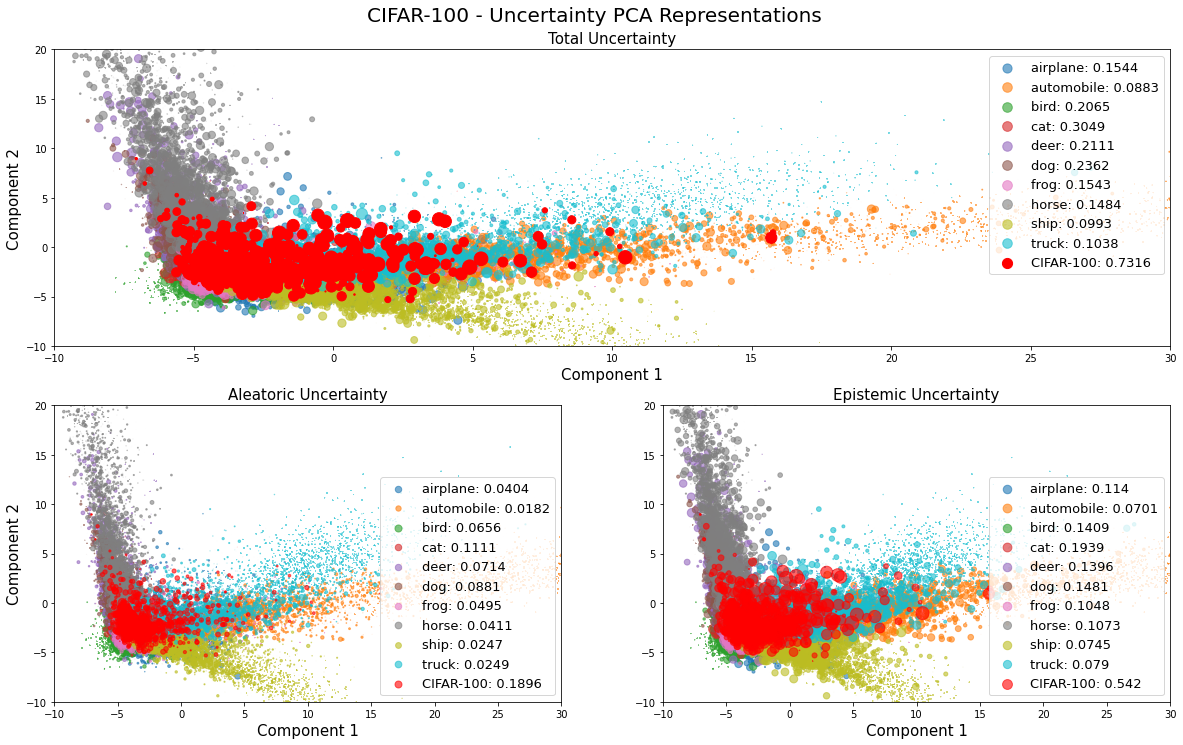

In [ ]:
# Prepare figure
fig = plt.figure(figsize=(20,12))
scale = 100

# Plot PCA Total Uncertainty
ax1 = fig.add_subplot(2,2, (1,2))
for g in np.unique(train_labels_plot):
    ix = np.where(train_labels_plot == g)
    av_uncertain = np.round(np.mean(np.array(train_total_uncertainties)[ix]), 4)
    ax1.scatter(pcax[ix], pcay[ix], label = '{}: {}'.format(cdict[g], av_uncertain),
                alpha=0.6, s=train_total_uncertainties[ix]*scale)
cifar100_av_uncertain = np.round(np.mean(cifar100_total_uncertainties), 4)

ax1.scatter(pcax_cifar100, pcay_cifar100, label="CIFAR-100: {}".format(cifar100_av_uncertain),
              c='red', s=cifar100_total_uncertainties*scale)
ax1.set_title('Total Uncertainty', fontsize=15)
ax1.set_xlabel('Component 1', fontsize=15)
ax1.set_ylabel('Component 2', fontsize=15)
ax1.legend(loc=1, fontsize=13)
ax1.set_xlim(-10,30)
ax1.set_ylim(-10,20)

# Plot PCA Aleatoric Uncertainty
ax2 = fig.add_subplot(2,2,3)
for g in np.unique(train_labels_plot):
    ix = np.where(train_labels_plot == g)
    av_uncertain = np.round(np.mean(np.array(train_alea_uncertainties)[ix]), 4)
    ax2.scatter(pcax[ix], pcay[ix], label = '{}: {}'.format(cdict[g], av_uncertain),
                alpha=0.6, s=train_alea_uncertainties[ix]*scale)
cifar100_av_uncertain = np.round(np.mean(cifar100_alea_uncertainties), 4)

ax2.scatter(pcax_cifar100, pcay_cifar100, label="CIFAR-100: {}".format(cifar100_av_uncertain),
              c='red', s=cifar100_alea_uncertainties*scale, alpha=0.6)
ax2.set_title('Aleatoric Uncertainty', fontsize=15)
ax2.set_xlabel('Component 1', fontsize=15)
ax2.set_ylabel('Component 2', fontsize=15)
ax2.legend(fontsize=13)
ax2.set_xlim(-10,30)
ax2.set_ylim(-10,20)

# Plot PCA Epistemic Uncertainty
ax3 = fig.add_subplot(2,2,4)
for g in np.unique(train_labels_plot):
    ix = np.where(train_labels_plot == g)
    av_uncertain = np.round(np.mean(np.array(train_epistemic_uncertainties)[ix]), 4)
    ax3.scatter(pcax[ix], pcay[ix], label = '{}: {}'.format(cdict[g], av_uncertain),
                alpha = 0.6, s = train_epistemic_uncertainties[ix]*scale)
cifar100_av_uncertain = np.round(np.mean(cifar100_epistemic_uncertainties), 4)

ax3.scatter(pcax_cifar100, pcay_cifar100, label="CIFAR-100: {}".format(cifar100_av_uncertain),
              c='red', s=cifar100_epistemic_uncertainties*scale, alpha=0.6)
ax3.set_title('Epistemic Uncertainty', fontsize=15)
ax3.set_xlabel('Component 1', fontsize=15)
ax3.legend(fontsize=13)
ax3.set_xlim(-10,30)
ax3.set_ylim(-10,20)

plt.suptitle("CIFAR-100 - Uncertainty PCA Representations", fontsize=20, y=.93)
plt.show()

#### Plot CelebA Uncertainty

Next, we plot CelebA OOD points and uncertainties to understand its performance relative to in-sample points.

In [ ]:
# Perform PCA to retrieve explained variance
pca = PCA(n_components=2)
pca.fit(phi_train)
print(pca.explained_variance_ratio_)

# Apply PCA transformation
pca_projection = pca.transform(phi_train)
pcax, pcay = pca_projection[:, 0], pca_projection[:, 1]

pca_celeba = pca.transform(phi_celeba)
pcax_celeba, pcay_celeba = pca_celeba[:, 0], pca_celeba[:, 1]


[0.18791525 0.10274289]


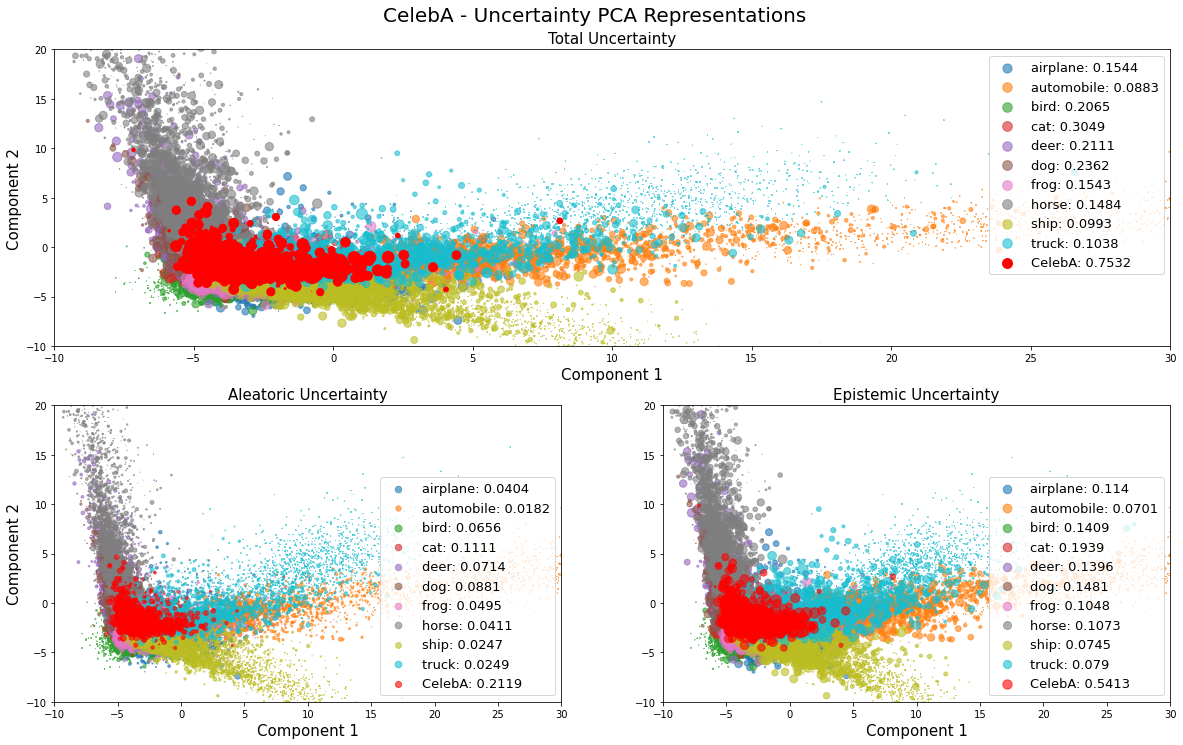

In [ ]:
# Prepare figure
fig = plt.figure(figsize=(20,12))
scale = 100

# Plot PCA Total Uncertainty
ax1 = fig.add_subplot(2,2, (1,2))
for g in np.unique(train_labels_plot):
    ix = np.where(train_labels_plot == g)
    av_uncertain = np.round(np.mean(np.array(train_total_uncertainties)[ix]), 4)
    ax1.scatter(pcax[ix], pcay[ix], label = '{}: {}'.format(cdict[g], av_uncertain),
                alpha=0.6, s=train_total_uncertainties[ix]*scale)
celeba_av_uncertain = np.round(np.mean(celeba_total_uncertainties), 4)

ax1.scatter(pcax_celeba, pcay_celeba, label="CelebA: {}".format(celeba_av_uncertain),
              c='red', s=celeba_total_uncertainties*scale)
ax1.set_title('Total Uncertainty', fontsize=15)
ax1.set_xlabel('Component 1', fontsize=15)
ax1.set_ylabel('Component 2', fontsize=15)
ax1.legend(loc=1, fontsize=13)
ax1.set_xlim(-10,30)
ax1.set_ylim(-10,20)

# Plot PCA Aleatoric Uncertainty
ax2 = fig.add_subplot(2,2,3)
for g in np.unique(train_labels_plot):
    ix = np.where(train_labels_plot == g)
    av_uncertain = np.round(np.mean(np.array(train_alea_uncertainties)[ix]), 4)
    ax2.scatter(pcax[ix], pcay[ix], label = '{}: {}'.format(cdict[g], av_uncertain),
                alpha=0.6, s=train_alea_uncertainties[ix]*scale)
celeba_av_uncertain = np.round(np.mean(celeba_alea_uncertainties), 4)

ax2.scatter(pcax_celeba, pcay_celeba, label="CelebA: {}".format(celeba_av_uncertain),
              c='red', s=celeba_alea_uncertainties*scale, alpha=0.6)
ax2.set_title('Aleatoric Uncertainty', fontsize=15)
ax2.set_xlabel('Component 1', fontsize=15)
ax2.set_ylabel('Component 2', fontsize=15)
ax2.legend(fontsize=13)
ax2.set_xlim(-10,30)
ax2.set_ylim(-10,20)

# Plot PCA Epistemic Uncertainty
ax3 = fig.add_subplot(2,2,4)
for g in np.unique(train_labels_plot):
    ix = np.where(train_labels_plot == g)
    av_uncertain = np.round(np.mean(np.array(train_epistemic_uncertainties)[ix]), 4)
    ax3.scatter(pcax[ix], pcay[ix], label = '{}: {}'.format(cdict[g], av_uncertain),
                alpha = 0.6, s = train_epistemic_uncertainties[ix]*scale)
celeba_av_uncertain = np.round(np.mean(celeba_epistemic_uncertainties), 4)

ax3.scatter(pcax_celeba, pcay_celeba, label="CelebA: {}".format(celeba_av_uncertain),
              c='red', s=celeba_epistemic_uncertainties*scale, alpha=0.6)
ax3.set_title('Epistemic Uncertainty', fontsize=15)
ax3.set_xlabel('Component 1', fontsize=15)
ax3.legend(fontsize=13)
ax3.set_xlim(-10,30)
ax3.set_ylim(-10,20)

plt.suptitle("CelebA - Uncertainty PCA Representations", fontsize=20, y=.93)
plt.show()

#### Plotting MNIST Uncertainty

We conclude with plots for MNIST OOD points.

In [ ]:
pca = PCA(n_components=2)
pca.fit(phi_train)
print(pca.explained_variance_ratio_)

pca_projection = pca.transform(phi_train)
pcax, pcay = pca_projection[:, 0], pca_projection[:, 1]

pca_mnist = pca.transform(phi_mnist)
pcax_mnist, pcay_mnist = pca_mnist[:, 0], pca_mnist[:, 1]

[0.18791518 0.10274296]


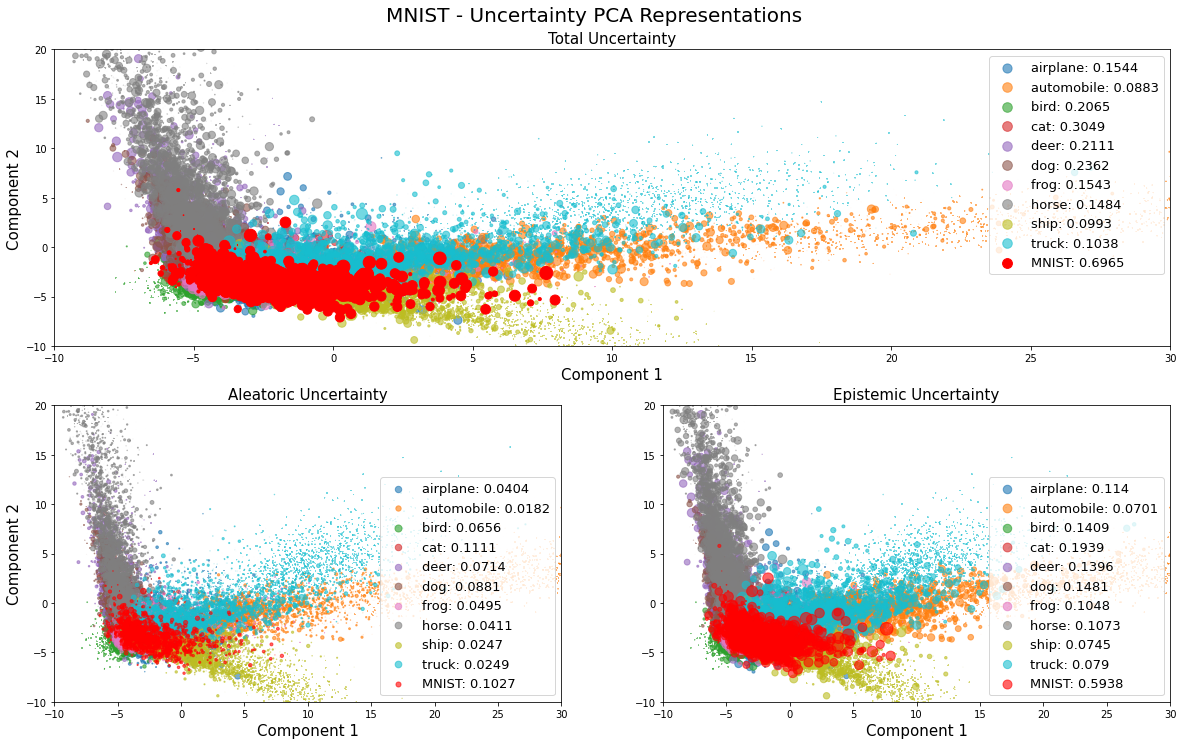

In [ ]:
# Prepare figure
fig = plt.figure(figsize=(20,12))
scale = 100

# Plot PCA Total Uncertainty
ax1 = fig.add_subplot(2,2, (1,2))
for g in np.unique(train_labels_plot):
    ix = np.where(train_labels_plot == g)
    av_uncertain = np.round(np.mean(np.array(train_total_uncertainties)[ix]), 4)
    ax1.scatter(pcax[ix], pcay[ix], label = '{}: {}'.format(cdict[g], av_uncertain),
                alpha=0.6, s=train_total_uncertainties[ix]*scale)
mnist_av_uncertain = np.round(np.mean(mnist_total_uncertainties), 4)

ax1.scatter(pcax_mnist, pcay_mnist, label="MNIST: {}".format(mnist_av_uncertain),
              c='red', s=mnist_total_uncertainties*scale)
ax1.set_title('Total Uncertainty', fontsize=15)
ax1.set_xlabel('Component 1', fontsize=15)
ax1.set_ylabel('Component 2', fontsize=15)
ax1.legend(loc=1, fontsize=13)
ax1.set_xlim(-10,30)
ax1.set_ylim(-10,20)

# Plot PCA Aleatoric Uncertainty
ax2 = fig.add_subplot(2,2,3)
for g in np.unique(train_labels_plot):
    ix = np.where(train_labels_plot == g)
    av_uncertain = np.round(np.mean(np.array(train_alea_uncertainties)[ix]), 4)
    ax2.scatter(pcax[ix], pcay[ix], label = '{}: {}'.format(cdict[g], av_uncertain),
                alpha=0.6, s=train_alea_uncertainties[ix]*scale)
mnist_av_uncertain = np.round(np.mean(mnist_alea_uncertainties), 4)

ax2.scatter(pcax_mnist, pcay_mnist, label="MNIST: {}".format(mnist_av_uncertain),
              c='red', s=mnist_alea_uncertainties*scale, alpha=0.6)
ax2.set_title('Aleatoric Uncertainty', fontsize=15)
ax2.set_xlabel('Component 1', fontsize=15)
ax2.set_ylabel('Component 2', fontsize=15)
ax2.legend(fontsize=13)
ax2.set_xlim(-10,30)
ax2.set_ylim(-10,20)

# Plot PCA Epistemic Uncertainty
ax3 = fig.add_subplot(2,2,4)
for g in np.unique(train_labels_plot):
    ix = np.where(train_labels_plot == g)
    av_uncertain = np.round(np.mean(np.array(train_epistemic_uncertainties)[ix]), 4)
    ax3.scatter(pcax[ix], pcay[ix], label = '{}: {}'.format(cdict[g], av_uncertain),
                alpha = 0.6, s = train_epistemic_uncertainties[ix]*scale)
mnist_av_uncertain = np.round(np.mean(mnist_epistemic_uncertainties), 4)

ax3.scatter(pcax_mnist, pcay_mnist, label="MNIST: {}".format(mnist_av_uncertain),
              c='red', s=mnist_epistemic_uncertainties*scale, alpha=0.6)
ax3.set_title('Epistemic Uncertainty', fontsize=15)
ax3.set_xlabel('Component 1', fontsize=15)
ax3.legend(fontsize=13)
ax3.set_xlim(-10,30)
ax3.set_ylim(-10,20)

plt.suptitle("MNIST - Uncertainty PCA Representations", fontsize=20, y=.93)
plt.show()

#### Comparing uncertainties

We compare density plots for the uncertainties on our different datasets to understand whether our OOD uncertainty distributions are noticeably different from our train and test datasets.

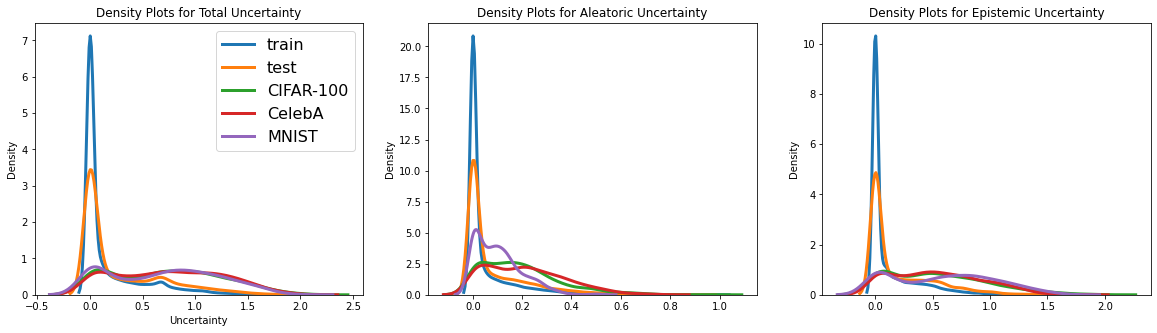

In [ ]:
# Prepare figure
fig = plt.figure(figsize=(20,5))

# Adding density plots
fig.add_subplot(1,3,1)
plt.title('Density Plots for Total Uncertainty')
sns.distplot(train_total_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="train")
sns.distplot(test_total_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="test")
sns.distplot(cifar100_total_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="CIFAR-100")
sns.distplot(celeba_total_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="CelebA")
sns.distplot(mnist_total_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="MNIST")
plt.legend(prop={'size': 16})
plt.xlabel('Uncertainty')
plt.ylabel('Density')

fig.add_subplot(1,3,2)
plt.title('Density Plots for Aleatoric Uncertainty')
sns.distplot(train_alea_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="train")
sns.distplot(test_alea_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="test")
sns.distplot(cifar100_alea_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="CIFAR-100")
sns.distplot(celeba_alea_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="CelebA")
sns.distplot(mnist_alea_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="MNIST")


fig.add_subplot(1,3,3)
plt.title('Density Plots for Epistemic Uncertainty')
sns.distplot(train_epistemic_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="train")
sns.distplot(test_epistemic_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="test")
sns.distplot(cifar100_epistemic_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="CIFAR-100")
sns.distplot(celeba_epistemic_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="CelebA")
sns.distplot(mnist_epistemic_uncertainties, hist=False, kde=True, kde_kws={'linewidth': 3}, label="MNIST")

# Plot formatting
plt.show()

We can see from the three density plots that OOD uncertainty is skewed towards larger values for all three OOD test datasets. This appears largely driven by epistemic uncertainty, which consistently flattens for all OOD data its density plot. For aleatoric uncertainty, we see varying behaviors. CIFAR-100 and CelebA appear to operate similarly, which makes sense given they are the most similar in underlying form - full color images of real objects. MNIST and its handwritten numbers shows a much more pronounced right-skew, similar in form as our train and test datasets but not as pronounced around the low uncertainty values.

---

## Section 3: Discussion of Broader Impact

While cutting-edge machine learning models are achieving increasingly impressive levels of intelligence, their implementation in practice is not so straightforward. Even if on paper the quantitative performance of an algorithm easily beats a human at a particular task, people will still prefer a human decision-process over an automated one. 

Therefore, there is a drastic need for models that can build trust in their decision-making. One major reason why people don't trust machines to make decisions is that there is always a chance the machine is exposed to a situation for which it has not been trained and makes an uninformed decision. Definitely in scenarios with high-stake decisions, this could have drastic consequences.  

Imagine a machine learning application in healthcare, where the model is used to predict a diagnosis and corresponding treatment. It is definitely possible that at inference time, the input data will be entirely different than the training data, e.g., because the person considered might have some rare condition, and we can't trust the model to make an accurate decision. We want the model to say its prediction is not reliable so that we can ask a human expert to jump in.  

For this, OOD detection is crucial! When implemented correctly, the model is able to warn the user not to trust its predictions when it is asked to make a decision based on input it is not familar with. 

The BaCOUn framework as introduced by the paper and analysed in this project, proves to be a powerful novel approach that answers this crucial need. All experiments show that the method returns high epistemic and low aleatoric uncertainty for a variety of OOD points. This makes us confident in its ability to detect OOD data across a spectrum of applications. Furthermore, the framework can easily be plugged into any kind of classification machine learning model and is thus very generalizable. 

Overall, the paper and this project have made us realize the importance of OOD detection in machine learning and the various methods that exist for doing so. It is clear how the BaCOUn framework is a very useful contribution in the space of trust-building in artificial intelligence. 